In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil

In [2]:
# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 650
IMAGE_WIDTH = 450

SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
EPOCHS = 1000
NUM_CLASSES = len(os.listdir(train_dir))

In [3]:
# Resample function to balance each class to 500 samples
def resample_data(directory, target_count=500):
    class_dirs = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]
    for class_dir in class_dirs:
        class_path = os.path.join(directory, class_dir)
        images = glob(os.path.join(class_path, "*.jpg"))
        current_count = len(images)
        if current_count < target_count:
            # Augment the class to have `target_count` images
            for i in range(target_count - current_count):
                image = images[i % current_count]
                image_name = os.path.basename(image)
                new_image_name = f"aug_{i}_{image_name}"
                new_image_path = os.path.join(class_path, new_image_name)
                shutil.copy(image, new_image_path)
        elif current_count > target_count:
            # Reduce the class to `target_count` images
            for image in images[target_count:]:
                os.remove(image)
                

In [4]:
## Resample training data
#resample_data(train_dir)


# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 8018 images belonging to 7 classes.
Found 2005 images belonging to 7 classes.
Found 1515 images belonging to 7 classes.


In [5]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
import os

# Load the InceptionResNetV2 model without the top fully connected layers (include_top=False)
base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))

# Freeze the base_model layers to prevent them from being trained
for layer in base_model.layers[-30:]:
    layer.trainable = False
    
## Unfreeze the top layers for fine-tuning
#for layer in base_model.layers[-30:]:
#    layer.trainable = True

# Add custom layers on top of the base model without L2 regularization
x = base_model.output
x = Dropout(0.3)(x)
x = GlobalAveragePooling2D()(x)

# Add Dense layers without L2 regularization   
x = Dense(256, activation='relu')(x)       
x = BatchNormalization()(x) 
x = Dropout(0.3)(x)                   
x = Dense(128, activation='relu')(x)    
x = BatchNormalization()(x)          
x = Dropout(0.3)(x)                   
x = Flatten()(x)                      
x = Dense(64, activation='relu')(x)     
x = Dropout(0.3)(x)                    
x = Dense(32, activation='relu')(x)     


# Final output layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['acc'])

# Summary of the model
model.summary()

# Metrics callback for precision
class MetricsCallback(Callback):
    def __init__(self, val_generator):
        super(MetricsCallback, self).__init__()
        self.val_generator = val_generator

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.val_generator.classes
        y_pred = self.model.predict(self.val_generator)
        y_pred_classes = np.argmax(y_pred, axis=1)

        # Calculate precision only
        precision, _, _, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

        val_loss = logs['val_loss']
        val_accuracy = logs.get('val_accuracy', logs.get('val_acc'))  # Handle different versions

        print(f'Epoch {epoch + 1} - '
              f'Validation Loss: {val_loss:.4f}, '
              f'Validation Accuracy: {val_accuracy:.4f}, '
              f'Validation Precision: {precision:.4f}')

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Metrics callback
metrics_callback = MetricsCallback(val_generator)

from tensorflow.keras.callbacks import ModelCheckpoint

# Define the callback to save the best model
checkpoint = ModelCheckpoint( 
    'withoutresample and regulazation7.h5',       # Path to save the model
    monitor='val_loss',     # Metric to monitor ('val_loss' or 'val_accuracy')
    save_best_only=True,    # Save only the best model
    mode='min',             # Save model when the validation loss decreases ('min' for loss, 'max' for accuracy)
    verbose=1
)

# Train the model with ModelCheckpoint
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=[early_stopping, metrics_callback, checkpoint, reduce_lr],
    verbose=2
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 650, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 656, 456, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 325, 225, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 574s - loss: 1.4219 - acc: 0.4834 - val_loss: 5.2517 - val_acc: 0.6494 - lr: 1.0000e-04 - 574s/epoch - 1s/step
Epoch 2/1000
126/126 [==============================] - 34s 268ms/step
Epoch 2 - Validation Loss: 1.0554, Validation Accuracy: 0.6713, Validation Precision: 0.5009

Epoch 2: val_loss improved from 5.25169 to 1.05539, saving model to withoutresample and regulazation7.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 558s - loss: 0.9221 - acc: 0.6793 - val_loss: 1.0554 - val_acc: 0.6713 - lr: 1.0000e-04 - 558s/epoch - 1s/step
Epoch 3/1000
126/126 [==============================] - 34s 268ms/step
Epoch 3 - Validation Loss: 3.0566, Validation Accuracy: 0.3352, Validation Precision: 0.6599

Epoch 3: val_loss did not improve from 1.05539
502/502 - 557s - loss: 0.8971 - acc: 0.6808 - val_loss: 3.0566 - val_acc: 0.3352 - lr: 1.0000e-04 - 557s/epoch - 1s/step
Epoch 4/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 268ms/step
Epoch 4 - Validation Loss: 1.0874, Validation Accuracy: 0.6090, Validation Precision: 0.7634

Epoch 4: val_loss did not improve from 1.05539
502/502 - 557s - loss: 0.8281 - acc: 0.7043 - val_loss: 1.0874 - val_acc: 0.6090 - lr: 1.0000e-04 - 557s/epoch - 1s/step
Epoch 5/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 5 - Validation Loss: 0.6668, Validation Accuracy: 0.7636, Validation Precision: 0.7421

Epoch 5: val_loss improved from 1.05539 to 0.66678, saving model to withoutresample and regulazation7.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 557s - loss: 0.7998 - acc: 0.7118 - val_loss: 0.6668 - val_acc: 0.7636 - lr: 1.0000e-04 - 557s/epoch - 1s/step
Epoch 6/1000
126/126 [==============================] - 34s 268ms/step
Epoch 6 - Validation Loss: 1.0330, Validation Accuracy: 0.5815, Validation Precision: 0.7439

Epoch 6: val_loss did not improve from 0.66678
502/502 - 557s - loss: 0.7755 - acc: 0.7195 - val_loss: 1.0330 - val_acc: 0.5815 - lr: 1.0000e-04 - 557s/epoch - 1s/step
Epoch 7/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 268ms/step
Epoch 7 - Validation Loss: 0.9905, Validation Accuracy: 0.6419, Validation Precision: 0.7521

Epoch 7: val_loss did not improve from 0.66678
502/502 - 557s - loss: 0.7435 - acc: 0.7361 - val_loss: 0.9905 - val_acc: 0.6419 - lr: 1.0000e-04 - 557s/epoch - 1s/step
Epoch 8/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 269ms/step
Epoch 8 - Validation Loss: 0.6495, Validation Accuracy: 0.7691, Validation Precision: 0.7459

Epoch 8: val_loss improved from 0.66678 to 0.64946, saving model to withoutresample and regulazation7.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 557s - loss: 0.7247 - acc: 0.7360 - val_loss: 0.6495 - val_acc: 0.7691 - lr: 1.0000e-04 - 557s/epoch - 1s/step
Epoch 9/1000
126/126 [==============================] - 34s 268ms/step
Epoch 9 - Validation Loss: 2.0027, Validation Accuracy: 0.6663, Validation Precision: 0.4713

Epoch 9: val_loss did not improve from 0.64946
502/502 - 557s - loss: 0.7055 - acc: 0.7469 - val_loss: 2.0027 - val_acc: 0.6663 - lr: 1.0000e-04 - 557s/epoch - 1s/step
Epoch 10/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 268ms/step
Epoch 10 - Validation Loss: 0.7943, Validation Accuracy: 0.7446, Validation Precision: 0.7090

Epoch 10: val_loss did not improve from 0.64946
502/502 - 556s - loss: 0.7267 - acc: 0.7388 - val_loss: 0.7943 - val_acc: 0.7446 - lr: 1.0000e-04 - 556s/epoch - 1s/step
Epoch 11/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 268ms/step
Epoch 11 - Validation Loss: 0.8042, Validation Accuracy: 0.7167, Validation Precision: 0.7866

Epoch 11: val_loss did not improve from 0.64946
502/502 - 557s - loss: 0.6810 - acc: 0.7575 - val_loss: 0.8042 - val_acc: 0.7167 - lr: 1.0000e-04 - 557s/epoch - 1s/step
Epoch 12/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 268ms/step
Epoch 12 - Validation Loss: 0.5962, Validation Accuracy: 0.7716, Validation Precision: 0.7953

Epoch 12: val_loss improved from 0.64946 to 0.59616, saving model to withoutresample and regulazation7.h5


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 - 558s - loss: 0.6478 - acc: 0.7614 - val_loss: 0.5962 - val_acc: 0.7716 - lr: 1.0000e-04 - 558s/epoch - 1s/step
Epoch 13/1000
126/126 [==============================] - 34s 268ms/step
Epoch 13 - Validation Loss: 1.0607, Validation Accuracy: 0.7067, Validation Precision: 0.6978

Epoch 13: val_loss did not improve from 0.59616
502/502 - 557s - loss: 0.6772 - acc: 0.7527 - val_loss: 1.0607 - val_acc: 0.7067 - lr: 1.0000e-04 - 557s/epoch - 1s/step
Epoch 14/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 268ms/step
Epoch 14 - Validation Loss: 0.6551, Validation Accuracy: 0.7656, Validation Precision: 0.7812

Epoch 14: val_loss did not improve from 0.59616
502/502 - 557s - loss: 0.6568 - acc: 0.7647 - val_loss: 0.6551 - val_acc: 0.7656 - lr: 1.0000e-04 - 557s/epoch - 1s/step
Epoch 15/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 268ms/step
Epoch 15 - Validation Loss: 0.9127, Validation Accuracy: 0.6579, Validation Precision: 0.7584

Epoch 15: val_loss did not improve from 0.59616
502/502 - 557s - loss: 0.7012 - acc: 0.7517 - val_loss: 0.9127 - val_acc: 0.6579 - lr: 1.0000e-04 - 557s/epoch - 1s/step
Epoch 16/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 268ms/step
Epoch 16 - Validation Loss: 0.6645, Validation Accuracy: 0.7736, Validation Precision: 0.8120

Epoch 16: val_loss did not improve from 0.59616
502/502 - 556s - loss: 0.6529 - acc: 0.7618 - val_loss: 0.6645 - val_acc: 0.7736 - lr: 1.0000e-04 - 556s/epoch - 1s/step
Epoch 17/1000


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


126/126 [==============================] - 34s 268ms/step
Epoch 17 - Validation Loss: 1.1475, Validation Accuracy: 0.6419, Validation Precision: 0.7953

Epoch 17: val_loss did not improve from 0.59616
502/502 - 557s - loss: 0.6097 - acc: 0.7870 - val_loss: 1.1475 - val_acc: 0.6419 - lr: 1.0000e-04 - 557s/epoch - 1s/step


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [6]:
# Calculate precision, recall, and f1 score after training
y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')

print(f'Final Precision: {precision:.4f}')
print(f'Final Recall: {recall:.4f}')
print(f'Final F1 Score: {f1_score:.4f}')

126/126 [==============================] - 34s 268ms/step
Final Precision: 0.7953
Final Recall: 0.7716
Final F1 Score: 0.7722


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 26s 271ms/step - loss: 0.8150 - acc: 0.7076
Test accuracy: 0.7075907588005066


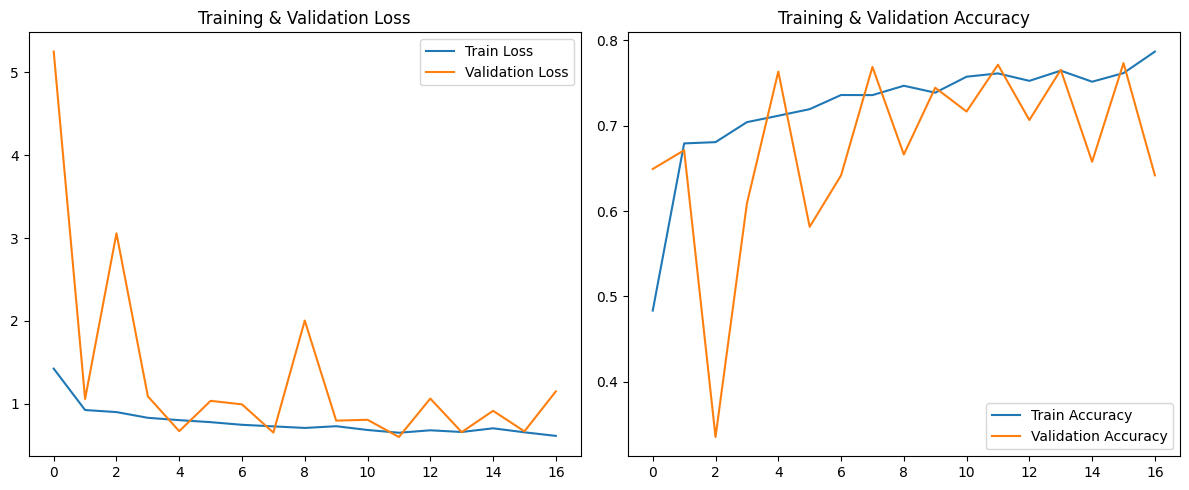

In [7]:
# Evaluate the model on the test set
test_score = model.evaluate(test_generator)
print('Test accuracy:', test_score[1])

# Plot the training and validation accuracy and loss at each epoch
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot Training & Validation Loss
axs[0].plot(history.history['loss'], label='Train Loss')
axs[0].plot(history.history['val_loss'], label='Validation Loss')
axs[0].legend()
axs[0].set_title('Training & Validation Loss')

# Plot Training & Validation Accuracy
axs[1].plot(history.history['acc'], label='Train Accuracy')
axs[1].plot(history.history['val_acc'], label='Validation Accuracy')
axs[1].legend()
axs[1].set_title('Training & Validation Accuracy')

plt.tight_layout()
plt.show()

502/502 [==============================] - 231s 460ms/step


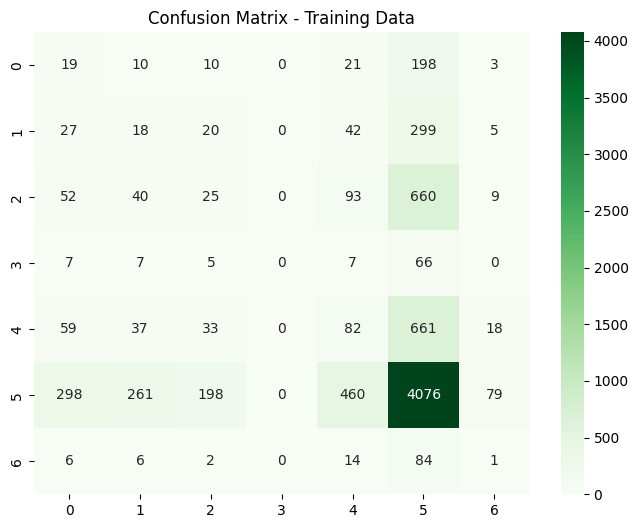

126/126 [==============================] - 33s 267ms/step


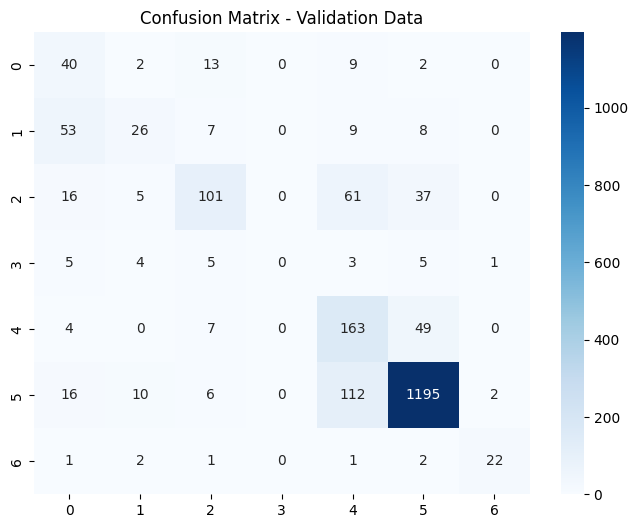

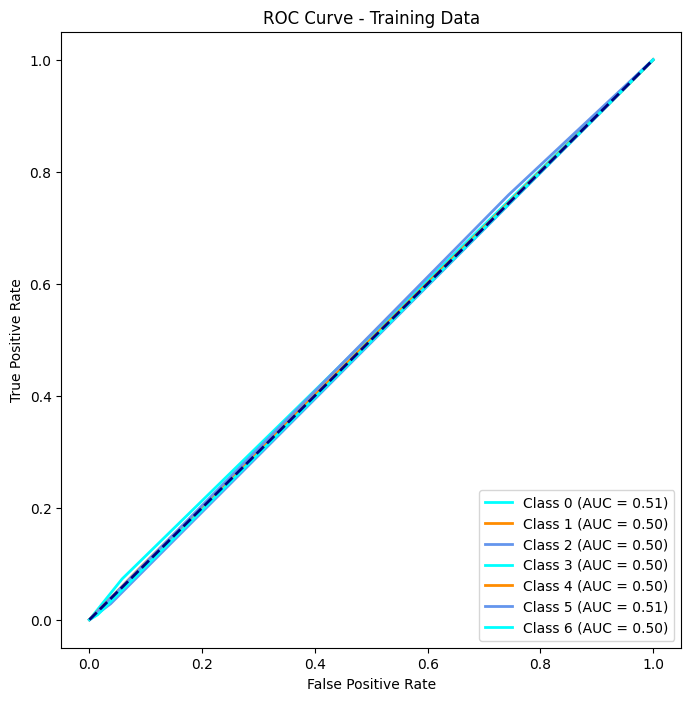

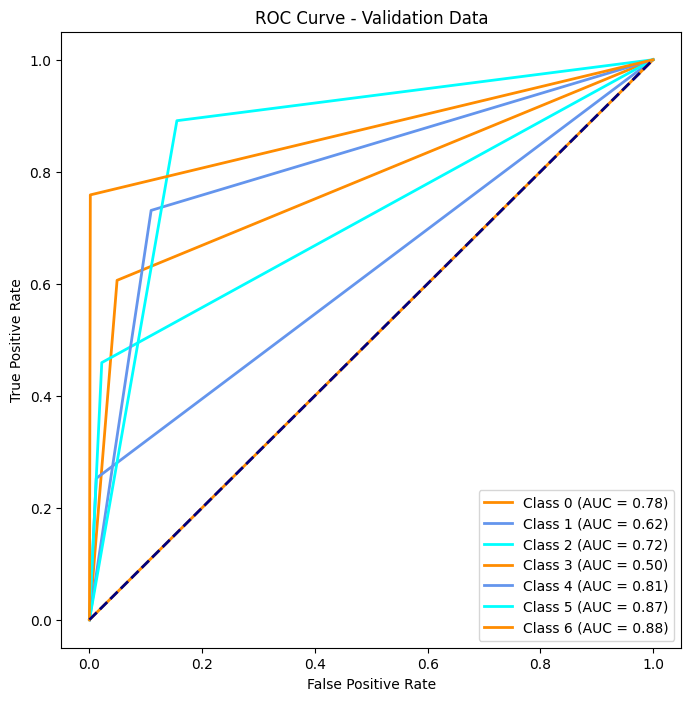

In [8]:
# Confusion matrix for training data
y_train_true = train_generator.classes
y_train_pred = model.predict(train_generator)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)
cm_train = confusion_matrix(y_train_true, y_train_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens')
plt.title('Confusion Matrix - Training Data')
plt.show()

# Confusion matrix for validation data
y_val_true = val_generator.classes
y_val_pred = model.predict(val_generator)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
cm_val = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_val, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Validation Data')
plt.show()

# AUC-ROC curve for training data
y_train_true_binary = label_binarize(y_train_true, classes=np.unique(y_train_true))
y_train_pred_binary = label_binarize(y_train_pred_classes, classes=np.unique(y_train_true))

fpr_train = dict()
tpr_train = dict()
roc_auc_train = dict()

for i in range(NUM_CLASSES):
    fpr_train[i], tpr_train[i], _ = roc_curve(y_train_true_binary[:, i], y_train_pred_binary[:, i])
    roc_auc_train[i] = roc_auc_score(y_train_true_binary[:, i], y_train_pred_binary[:, i])

plt.figure(figsize=(8, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])

for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_train[i], tpr_train[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_train[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Training Data')
plt.legend(loc='lower right')
plt.show()

# AUC-ROC curve for validation data
y_val_true_binary = label_binarize(y_val_true, classes=np.unique(y_val_true))
y_val_pred_binary = label_binarize(y_val_pred_classes, classes=np.unique(y_val_true))

fpr_val = dict()
tpr_val = dict()
roc_auc_val = dict()

for i in range(NUM_CLASSES):
    fpr_val[i], tpr_val[i], _ = roc_curve(y_val_true_binary[:, i], y_val_pred_binary[:, i])
    roc_auc_val[i] = roc_auc_score(y_val_true_binary[:, i], y_val_pred_binary[:, i])

plt.figure(figsize=(8, 8))
for i, color in zip(range(NUM_CLASSES), colors):
    plt.plot(fpr_val[i], tpr_val[i], color=color, lw=2, label=f'Class {i} (AUC = {roc_auc_val[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Data')
plt.legend(loc='lower right')
plt.show()


In [9]:
x, y  = train_generator.__getitem__(0)

y

array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [10]:
x, y  = test_generator.__getitem__(0)

y

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [11]:
x, y  = val_generator.__getitem__(0)

y

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]], dtype=float32)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 650, 450, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 656, 456, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 325, 225, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Train accuracy: 0.7852332252432028
Train Precision: 0.78201728516796
Train Recall: 0.7852332252432028
Train F1 Score: 0.7642203931368744
126/126 [==============================] - 36s 284ms/step
Val accuracy: 0.7625935162094764
Val Precision: 0.7975252060671914
Val Recall: 0.7625935162094764
Val F1 Score: 0.7649133138831267


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


95/95 [==============================] - 26s 279ms/step
Test Accuracy: 0.6963696369636964
Test Precision: 0.7233480294793706
Test Recall: 0.6963696369636964
Test F1 Score: 0.690033862424271


c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


502/502 [==============================] - 230s 458ms/step


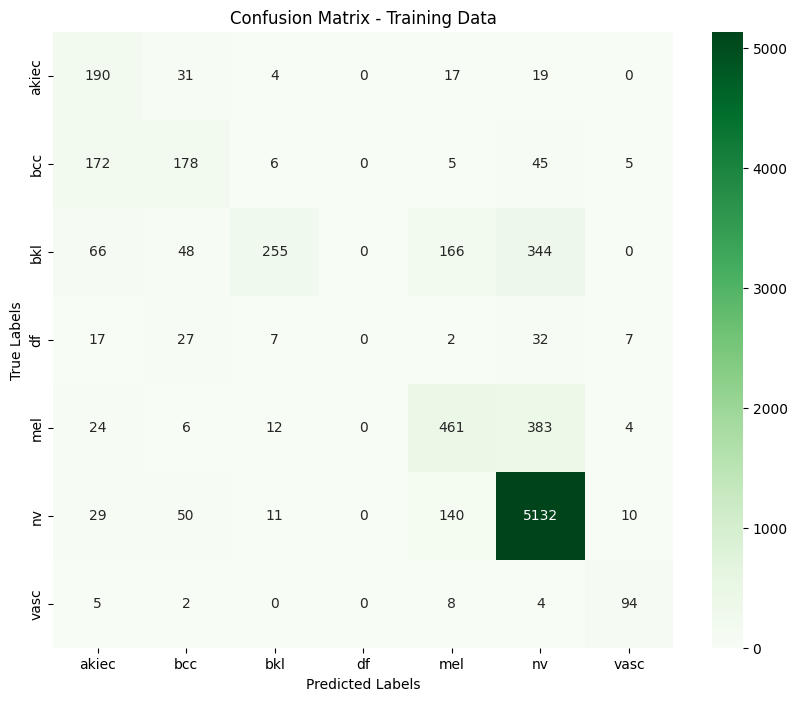

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Training Data:
              precision    recall  f1-score   support

       akiec       0.38      0.73      0.50       261
         bcc       0.52      0.43      0.47       411
         bkl       0.86      0.29      0.43       879
          df       0.00      0.00      0.00        92
         mel       0.58      0.52      0.55       890
          nv       0.86      0.96      0.91      5372
        vasc       0.78      0.83      0.81       113

    accuracy                           0.79      8018
   macro avg       0.57      0.54      0.52      8018
weighted avg       0.79      0.79      0.77      8018

126/126 [==============================] - 36s 284ms/step


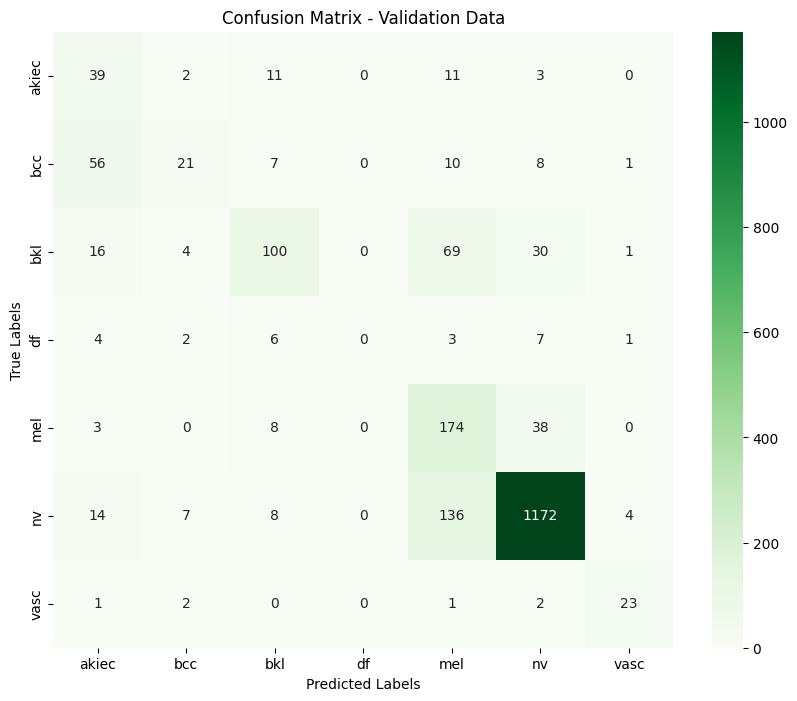

c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

Classification Report for Validation Data:
              precision    recall  f1-score   support

       akiec       0.29      0.59      0.39        66
         bcc       0.55      0.20      0.30       103
         bkl       0.71      0.45      0.56       220
          df       0.00      0.00      0.00        23
         mel       0.43      0.78      0.56       223
          nv       0.93      0.87      0.90      1341
        vasc       0.77      0.79      0.78        29

    accuracy                           0.76      2005
   macro avg       0.53      0.53      0.50      2005
weighted avg       0.80      0.76      0.76      2005

95/95 [==============================] - 27s 283ms/step


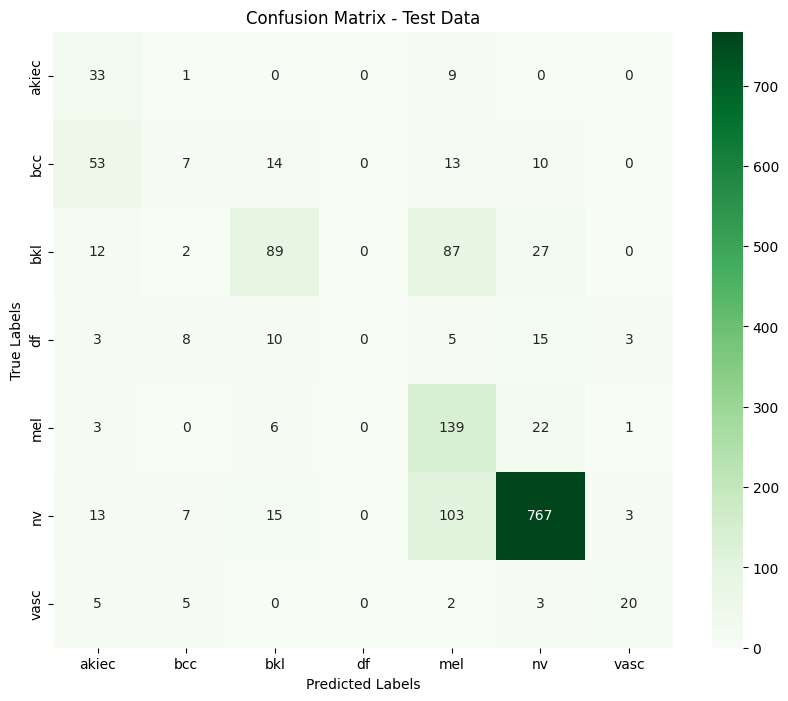

Classification Report for Test Data:
              precision    recall  f1-score   support

       akiec       0.27      0.77      0.40        43
         bcc       0.23      0.07      0.11        97
         bkl       0.66      0.41      0.51       217
          df       0.00      0.00      0.00        44
         mel       0.39      0.81      0.53       171
          nv       0.91      0.84      0.88       908
        vasc       0.74      0.57      0.65        35

    accuracy                           0.70      1515
   macro avg       0.46      0.50      0.44      1515
weighted avg       0.72      0.70      0.69      1515



c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\guitar123\anaconda3\envs\SeniorProject\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, label_binarize
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, Callback
from itertools import cycle
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from collections import Counter
import shutil
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model(r"C:\Users\guitar123\Desktop\Senior Project\Model2\original model\InceptionResnetV2\test resample\without resample\ResNet101\withoutresample and regulazation7.h5")

# Verify the model structure
model.summary()

# Paths
train_dir = r"C:\Users\guitar123\Desktop\Senior Project\dataset\HAM10000 Original\train"
val_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\val"
test_dir = r"C:\Users\guitar123\Desktop\Senior project\dataset\HAM10000\test"

# Constants
IMAGE_HEIGHT = 600
IMAGE_WIDTH = 450
SIZE = (IMAGE_HEIGHT, IMAGE_WIDTH)
IMAGE_CHANNELS = 3  # Assuming RGB images
BATCH_SIZE = 16
# Create ImageDataGenerator instances
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generate data from directories
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

y_true = train_generator.classes
y_pred = model.predict(train_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Train accuracy:', accuracy)
print('Train Precision:', precision)
print('Train Recall:', recall)
print('Train F1 Score:', f1_score)

y_true = val_generator.classes
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Val accuracy:', accuracy)
print('Val Precision:', precision)
print('Val Recall:', recall)
print('Val F1 Score:', f1_score)

y_true = test_generator.classes
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred_classes, average='weighted')
accuracy = np.mean(y_true == y_pred_classes)
print('Test Accuracy:', accuracy)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1_score)


from sklearn.metrics import classification_report
# Function to generate confusion matrix and classification report
def plot_confusion_matrix_and_report(generator, generator_name):
    # Get predictions
    predictions = model.predict(generator)
    predicted_classes = np.argmax(predictions, axis=1)

    # Get true labels
    true_classes = generator.classes
    class_labels = list(generator.class_indices.keys())

    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_classes, predicted_classes)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
    plt.title(f'Confusion Matrix - {generator_name} Data')
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.show()

    # Print classification report
    report = classification_report(true_classes, predicted_classes, target_names=class_labels)
    print(f'Classification Report for {generator_name} Data:')
    print(report)

# Plot confusion matrix and classification report for train, val, and test data
plot_confusion_matrix_and_report(train_generator, 'Training')
plot_confusion_matrix_and_report(val_generator, 'Validation')
plot_confusion_matrix_and_report(test_generator, 'Test')